## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import ReduceLROnPlateau



optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.7]
redice_lr_patient = [5,10,20]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0722 21:51:32.647495 49176 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 21:51:32.650484 49176 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 21:51:32.661457 49176 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 21:51:32.796092 49176 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5


W0722 21:51:33.211979 49176 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0722 21:51:33.231930 49176 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0722 21:51:33.401472 49176 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 17s 343us/step - loss: 1.1096 - acc: 0.6205 - val_loss: 1.4540 - val_acc: 0.4896
Epoch 19/20
50000/50000 [==============================] - 11s 217us/step - loss: 1.0866 - acc: 0.6297 - val_loss: 1.4699 - val_acc: 0.4860
Epoch 20/20
50000/50000 [==============================] - 11s 211us/step - loss: 1.0647 - acc: 0.6384 - val_loss: 1.4539 - val_acc: 0.4905
Numbers of exp: 2, reduce_factor: 0.30, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidde

50000/50000 [==============================] - 12s 238us/step - loss: 1.1799 - acc: 0.5955 - val_loss: 1.4693 - val_acc: 0.4844
Epoch 16/20
50000/50000 [==============================] - 12s 234us/step - loss: 1.1557 - acc: 0.6054 - val_loss: 1.4674 - val_acc: 0.4877
Epoch 17/20
50000/50000 [==============================] - 10s 195us/step - loss: 1.1301 - acc: 0.6149 - val_loss: 1.4674 - val_acc: 0.4875
Epoch 18/20
50000/50000 [==============================] - 7s 137us/step - loss: 1.1089 - acc: 0.6233 - val_loss: 1.4657 - val_acc: 0.4866
Epoch 19/20
50000/50000 [==============================] - 7s 146us/step - loss: 1.0882 - acc: 0.6305 - val_loss: 1.4629 - val_acc: 0.4907
Epoch 20/20
50000/50000 [==============================] - 7s 143us/step - loss: 1.0634 - acc: 0.6401 - val_loss: 1.4622 - val_acc: 0.4908
Numbers of exp: 4, reduce_factor: 0.70, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape         

50000/50000 [==============================] - 8s 152us/step - loss: 1.2565 - acc: 0.5655 - val_loss: 1.4806 - val_acc: 0.4723
Epoch 13/20
50000/50000 [==============================] - 7s 143us/step - loss: 1.2317 - acc: 0.5752 - val_loss: 1.4703 - val_acc: 0.4803
Epoch 14/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.2057 - acc: 0.5852 - val_loss: 1.4677 - val_acc: 0.4818
Epoch 15/20
50000/50000 [==============================] - 7s 139us/step - loss: 1.1828 - acc: 0.5910 - val_loss: 1.4630 - val_acc: 0.4789
Epoch 16/20
50000/50000 [==============================] - 7s 150us/step - loss: 1.1593 - acc: 0.6035 - val_loss: 1.4632 - val_acc: 0.4836
Epoch 17/20
50000/50000 [==============================] - 7s 143us/step - loss: 1.1391 - acc: 0.6092 - val_loss: 1.4548 - val_acc: 0.4858
Epoch 18/20
50000/50000 [==============================] - 7s 138us/step - loss: 1.1124 - acc: 0.6192 - val_loss: 1.4554 - val_acc: 0.4901
Epoch 19/20
50000/50000 [==============

50000/50000 [==============================] - 7s 148us/step - loss: 1.1511 - acc: 0.6033 - val_loss: 1.4774 - val_acc: 0.4766
Epoch 9/20
50000/50000 [==============================] - 8s 152us/step - loss: 1.1119 - acc: 0.6182 - val_loss: 1.4935 - val_acc: 0.4692
Epoch 10/20
50000/50000 [==============================] - 8s 153us/step - loss: 1.0804 - acc: 0.6320 - val_loss: 1.4332 - val_acc: 0.4975
Epoch 11/20
50000/50000 [==============================] - 7s 148us/step - loss: 1.0446 - acc: 0.6450 - val_loss: 1.4488 - val_acc: 0.4876
Epoch 12/20
50000/50000 [==============================] - 7s 148us/step - loss: 1.0110 - acc: 0.6578 - val_loss: 1.4891 - val_acc: 0.4832
Epoch 13/20
50000/50000 [==============================] - 7s 148us/step - loss: 0.9828 - acc: 0.6669 - val_loss: 1.4798 - val_acc: 0.4781
Epoch 14/20
50000/50000 [==============================] - 7s 149us/step - loss: 0.9530 - acc: 0.6801 - val_loss: 1.4549 - val_acc: 0.4970
Epoch 15/20
50000/50000 [===============

Epoch 5/20
50000/50000 [==============================] - 8s 150us/step - loss: 1.4054 - acc: 0.5115 - val_loss: 1.5647 - val_acc: 0.4524
Epoch 6/20
50000/50000 [==============================] - 7s 150us/step - loss: 1.3641 - acc: 0.5267 - val_loss: 1.5670 - val_acc: 0.4510
Epoch 7/20
50000/50000 [==============================] - 7s 149us/step - loss: 1.3293 - acc: 0.5401 - val_loss: 1.5202 - val_acc: 0.4713
Epoch 8/20
50000/50000 [==============================] - 7s 149us/step - loss: 1.2969 - acc: 0.5520 - val_loss: 1.5065 - val_acc: 0.4773
Epoch 9/20
50000/50000 [==============================] - 8s 152us/step - loss: 1.2691 - acc: 0.5617 - val_loss: 1.5221 - val_acc: 0.4731
Epoch 10/20
50000/50000 [==============================] - 8s 166us/step - loss: 1.2436 - acc: 0.5737 - val_loss: 1.4798 - val_acc: 0.4835
Epoch 11/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.2207 - acc: 0.5825 - val_loss: 1.4771 - val_acc: 0.4868
Epoch 12/20
50000/50000 [=======

50000/50000 [==============================] - 7s 148us/step - loss: 1.6036 - acc: 0.4395 - val_loss: 1.7216 - val_acc: 0.4078
Epoch 3/20
50000/50000 [==============================] - 7s 149us/step - loss: 1.5109 - acc: 0.4725 - val_loss: 1.6309 - val_acc: 0.4292
Epoch 4/20
50000/50000 [==============================] - 7s 148us/step - loss: 1.4463 - acc: 0.4984 - val_loss: 1.5920 - val_acc: 0.4386
Epoch 5/20
50000/50000 [==============================] - 7s 148us/step - loss: 1.3997 - acc: 0.5151 - val_loss: 1.5849 - val_acc: 0.4416
Epoch 6/20
50000/50000 [==============================] - 7s 148us/step - loss: 1.3580 - acc: 0.5290 - val_loss: 1.5645 - val_acc: 0.4537
Epoch 7/20
50000/50000 [==============================] - 8s 151us/step - loss: 1.3277 - acc: 0.5415 - val_loss: 1.5369 - val_acc: 0.4708
Epoch 8/20
50000/50000 [==============================] - 7s 148us/step - loss: 1.2961 - acc: 0.5541 - val_loss: 1.5270 - val_acc: 0.4645
Epoch 9/20
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 187us/step - loss: 1.7962 - acc: 0.3818 - val_loss: 2.0102 - val_acc: 0.3391
Epoch 2/20
50000/50000 [==============================] - 7s 146us/step - loss: 1.5232 - acc: 0.4673 - val_loss: 1.9770 - val_acc: 0.3361
Epoch 3/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.4209 - acc: 0.5013 - val_loss: 2.0795 - val_acc: 0.3455
Epoch 4/20
50000/50000 [==============================] - 7s 146us/step - loss: 1.3432 - acc: 0.5316 - val_loss: 1.8090 - val_acc: 0.3951
Epoch 5/20
50000/50000 [==============================] - 7s 147us/step - loss: 1.2739 - acc: 0.5559 - val_loss: 1.9270 - val_acc: 0.3461
Epoch 6/20
50000/50000 [==============================] - 8s 156us/step - loss: 1.2258 - acc: 0.5741 - val_loss: 1.8785 - val_acc: 0.3631
Epoch 7/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.1838 - acc: 0.5870 - val_loss: 1.9087 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 206us/step - loss: 1.8126 - acc: 0.3765 - val_loss: 2.5575 - val_acc: 0.2751
Epoch 2/20
50000/50000 [==============================] - 8s 151us/step - loss: 1.5275 - acc: 0.4648 - val_loss: 2.7107 - val_acc: 0.2552
Epoch 3/20
50000/50000 [==============================] - 8s 164us/step - loss: 1.4219 - acc: 0.5001 - val_loss: 2.0121 - val_acc: 0.3326
Epoch 4/20
50000/50000 [==============================] - 9s 172us/step - loss: 1.3446 - acc: 0.5286 - val_loss: 2.3056 - val_acc: 0.3082
Epoch 5/20
50000/50000 [==============================] - 8s 155us/step - loss: 1.2939 - acc: 0.5476 - val_loss: 1.9840 - val_acc: 0.3661
Epoch 6/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.2315 - acc: 0.5709 - val_loss: 2.1666 - val_acc: 0.3048
Epoch 7/20
50000/50000 [==============================] - 7s 148us/step - loss: 1.1868 - acc: 0.5858 - val_loss: 2.1738 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 198us/step - loss: 1.8972 - acc: 0.3544 - val_loss: 2.4944 - val_acc: 0.2719
Epoch 2/20
50000/50000 [==============================] - 7s 147us/step - loss: 1.5833 - acc: 0.4475 - val_loss: 1.9672 - val_acc: 0.3594
Epoch 3/20
50000/50000 [==============================] - 7s 149us/step - loss: 1.4725 - acc: 0.4839 - val_loss: 1.9236 - val_acc: 0.3626
Epoch 4/20
50000/50000 [==============================] - 8s 153us/step - loss: 1.3933 - acc: 0.5132 - val_loss: 1.7831 - val_acc: 0.3955
Epoch 5/20
50000/50000 [==============================] - 7s 150us/step - loss: 1.3342 - acc: 0.5369 - val_loss: 2.0130 - val_acc: 0.3441
Epoch 6/20
50000/50000 [==============================] - 7s 149us/step - loss: 1.2804 - acc: 0.5553 - val_loss: 1.7818 - val_acc: 0.3950
Epoch 7/20
50000/50000 [==============================] - 8s 159us/step - loss: 1.2348 - acc: 0.5733 - val_loss: 1.8328 -

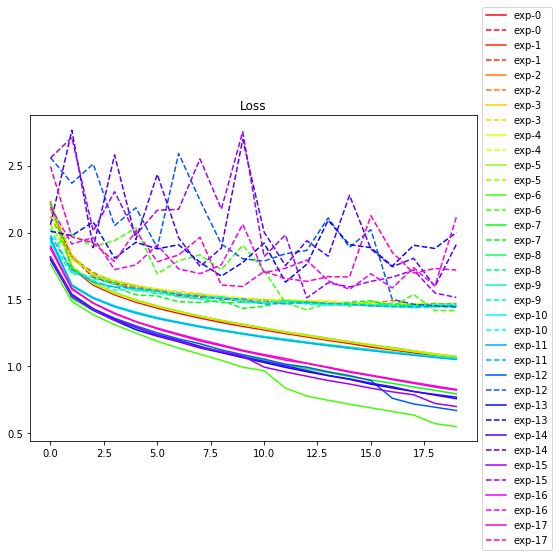

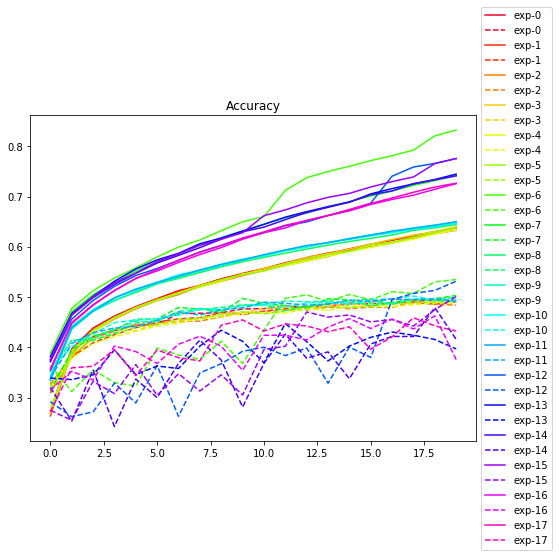

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()